## Agentic RAG

## What is Agentic RAG?

Agentic RAG is an advanced AI architecture that combines the reasoning capabilities of AI Agents with the data-grounding of Retrieval-Augmented Generation (RAG).

In short, instead of just passively retrieving information and answering, an Agentic RAG system actively reasons, plans, and decides the best way to answer a query.It can dynamically choose which tools to use, what to search for, and even refine its search multiple times to get the best possible answer.

## The Key Difference: A Simple Analogy
To understand the difference, think of a research assistant:
Standard RAG is like a junior assistant. You give it a fixed task: "1. Go to the library's vector database. 2. Pull the top 5 most relevant documents. 3. Give them to the writer (the LLM) to summarize." It's a fixed, linear pipeline: Retrieve $\rightarrow$ Augment $\rightarrow$ Generate.

Agentic RAG is like a senior researcher. You give it a complex question. The researcher (the agent) first thinks:"Is this question simple or complex?""Do I need external information, or is it in my memory?""Which tool is best? The vector database? A web search? A SQL database?"It then creates a plan, executes it (e.g., searches the web), looks at the results, and thinks again:4"Is this information good enough?""No, the first result is outdated. I will refine my query to search for more recent news."Only after it's satisfied with the gathered evidence does it generate the final answer. This is a dynamic, reasoning loop: Reason $\rightarrow$ Act $\rightarrow$ Observe $\rightarrow$ Reason ...

## Key Capabilities of an Agentic RAG System
What makes an Agentic RAG system "agentic" is its ability to perform these actions:

- Query Analysis and Planning: The agent first analyzes the user's query. It can break down a complex, multi-part question (e.g., "Compare the Q4 earnings of Company A and Company B") into a series of smaller, executable sub-tasks.

- Dynamic Tool Use (Routing): A standard RAG pipeline is usually connected to one tool (e.g., a single vector store). An agent can be given a toolbox and can decide which tool to use.

- This toolbox might include:A vector database for internal documentsA web search engine for real-time informationA SQL database for structured dataA calculator or code interpreter for computations8The agent acts as a "router," picking the right tool for the job.

- Iterative Retrieval (Self-Correction): This is a major advantage. An agent can retrieve information, inspect it for relevance, and if the information is poor or insufficient, it can autonomously decide to try again.It might reformulate the query, use a different tool, or search for clarifying information. This iterative loop is often called Corrective RAG (C-RAG) or Self-Reflective RAG (Self-RAG), which are specific types of agentic systems

In [2]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langchain_groq import ChatGroq

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [7]:
from langchain_openai import OpenAIEmbeddings
from langchain_groq import ChatGroq

embeddings=OpenAIEmbeddings()
llm=ChatGroq(model_name="qwen/qwen3-32b")

In [8]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list=[item for sublist in docs for item in sublist]
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)

In [9]:
doc_splits=text_splitter.split_documents(docs_list)

In [10]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)

In [11]:
retriever=vectorstore.as_retriever()

In [12]:
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000002A63E3D8440>, search_kwargs={})

In [13]:
retriever_tool=create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )

In [14]:
tools=[retriever_tool]
retrieve=ToolNode([retriever_tool])

Certainly! Let's break down the code:

### **Code Breakdown:**

```python
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
```

This code defines a class `AgentState` that is a **`TypedDict`**, which is a special kind of dictionary with fixed keys and value types, used to provide better type safety and autocompletion in Python.

Here’s a breakdown of each part:

---

### **1. `AgentState(TypedDict)`**
- **`TypedDict`**: This is a special class provided by `typing` that allows you to define dictionaries where each key has a fixed type. The dictionary keys are usually predefined, and each key must have a specified type.

  - `AgentState` here is a subclass of `TypedDict`, meaning `AgentState` will represent a dictionary where the types of its values are enforced.

  - Example:
    ```python
    agent_state = AgentState(messages=["Message 1", "Message 2"])  # This would be valid.
    ```

---

### **2. `messages: Annotated[Sequence[BaseMessage], add_messages]`**
- **`messages`**: This is a key in the `AgentState` dictionary. It holds a sequence (like a list or tuple) of `BaseMessage` objects.
  
- **`Annotated[...]`**: `Annotated` is used to attach additional metadata or annotations to the type. It’s a way to add extra information to the type system without affecting the actual type. In this case, it provides metadata for the `messages` field. 

  - The **`Annotated`** wrapper allows you to define a type and also include additional information that might be used by tools like static analyzers or for other purposes like validation.

- **`Sequence[BaseMessage]`**: This indicates that `messages` should be a sequence (e.g., a list or tuple) of `BaseMessage` objects.

  - **`BaseMessage`** is likely a class that represents a message in the context of your program. It could have fields like `content`, `sender`, `timestamp`, etc.
  
- **`add_messages`**: This is a special annotation (or metadata) that likely refers to some function or constant that’s being added as additional context. The specific role of `add_messages` will depend on how it's defined elsewhere in the codebase.

  - **`add_messages`** could be a function, validator, or modifier that helps manage or process the messages in some way, but it's not directly modifying the type of `messages`. It's simply metadata for the type checker or other parts of the system.

  - For example, if `add_messages` were a function, it could be used in a custom decorator, validation system, or simply as an indication of how to handle messages.

---

### **Putting It All Together:**

- **`AgentState`** is a dictionary where one of the keys, `messages`, is specifically typed to be a **sequence of `BaseMessage`** objects. The sequence is annotated with **`add_messages`**, which provides additional metadata but doesn’t affect the type directly.
  
- **Example of `AgentState` usage:**

```python
from typing import TypedDict, Sequence
from typing_extensions import Annotated

class BaseMessage:
    def __init__(self, content: str):
        self.content = content

# Defining the `AgentState` TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], "add_messages"]

# Example usage
message1 = BaseMessage("Hello, world!")
message2 = BaseMessage("How are you?")
state = AgentState(messages=[message1, message2])

print(state)
```

In the above code:
- `AgentState` is a dictionary with a `messages` field that is a sequence of `BaseMessage` objects.
- `add_messages` is metadata associated with the `messages` field, which can help guide the usage or interpretation of the data.

---

### **Summary:**
- `AgentState` is a dictionary where the `messages` key holds a sequence of `BaseMessage` objects.
- `Annotated[Sequence[BaseMessage], add_messages]` means that `messages` is a sequence of `BaseMessage` objects with additional metadata (`add_messages`).
- The annotation `add_messages` provides extra context or metadata that doesn't alter the type directly but can be used for purposes like validation or other system-specific behavior.


In [15]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [16]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
            
        chain = prompt | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [17]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [18]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [19]:
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [20]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [21]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [22]:
workflow=StateGraph(AgentState)
workflow.add_node("My_Ai_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewriter", rewrite) 

In [24]:
workflow.add_edge(START,"My_Ai_Assistant")
workflow.add_conditional_edges("My_Ai_Assistant",
                            tools_condition,
                            {"tools": "Vector_Retriever",
                                END: END,})

In [25]:
workflow.add_conditional_edges("Vector_Retriever",
                            grade_documents,
                            {"generator": "Output_Generator",
                            "rewriter": "Query_Rewriter"
                            }
                            )

In [26]:
workflow.add_edge("Output_Generator", END)
workflow.add_edge("Query_Rewriter", "My_Ai_Assistant")
app=workflow.compile()

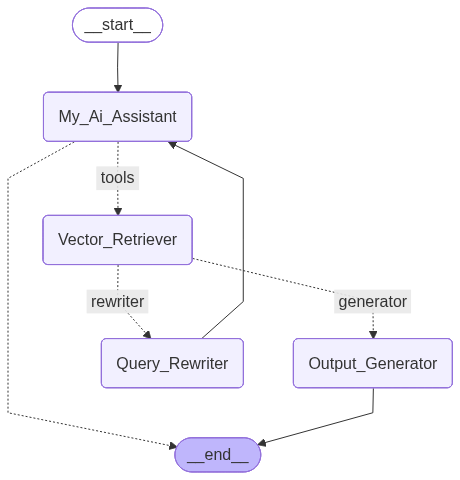

In [27]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='5ba51bf9-5c2d-4065-9c91-bfa675fe1b2c'),
  AIMessage(content='An autonomous agent is an entity in artificial intelligence (AI) that can operate independently, making decisions and taking actions based on its environment and goals without direct human intervention. These agents use sensors to perceive their surroundings, process information through algorithms or models (e.g., machine learning), and execute actions to achieve specific objectives. Examples include self-driving cars, chatbots, and robotic systems. They are designed to adapt dynamically to changing conditions and learn from experience over time.', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is an Autonomous Agent?" Let me think about how to approach this.\n\nFirst, I need to check if the user\'s query relates to the LangChain blog data. The question is general and doesn\'t mention any